### Movie Review Analysis
    Author : Paritosh Gaiwak, Pragam Gandhi, Sanjana Kacholia, Tushar Pahuja
    DataSet : IMDB
    Version 1 : Run 4 models and compared them on the basis of various metrics

#### Import necessary packages

In [205]:
import nltk
import re
import numpy as np
from nltk.corpus import stopwords
from sklearn.datasets import load_files
import tensorflow as tf
import pickle
nltk.download('stopwords')
import matplotlib.pyplot as plt
import xml.etree.ElementTree
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from tokenize import tokenize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load datasets

In [66]:
# Getting datasets
dataset = load_files('IMDB/')
reviews,label = dataset.data, dataset.target




#### Check number of samples - positive and negative

In [67]:
# Checking number of samples
print(len(reviews))
print(len(label))
#Positive samples
print(sum(x for x in label if x==1))
#Negative smaples
print(sum(1 for x in label if x==0))

50000
50000
25000
25000


#### Distribution of Review Length

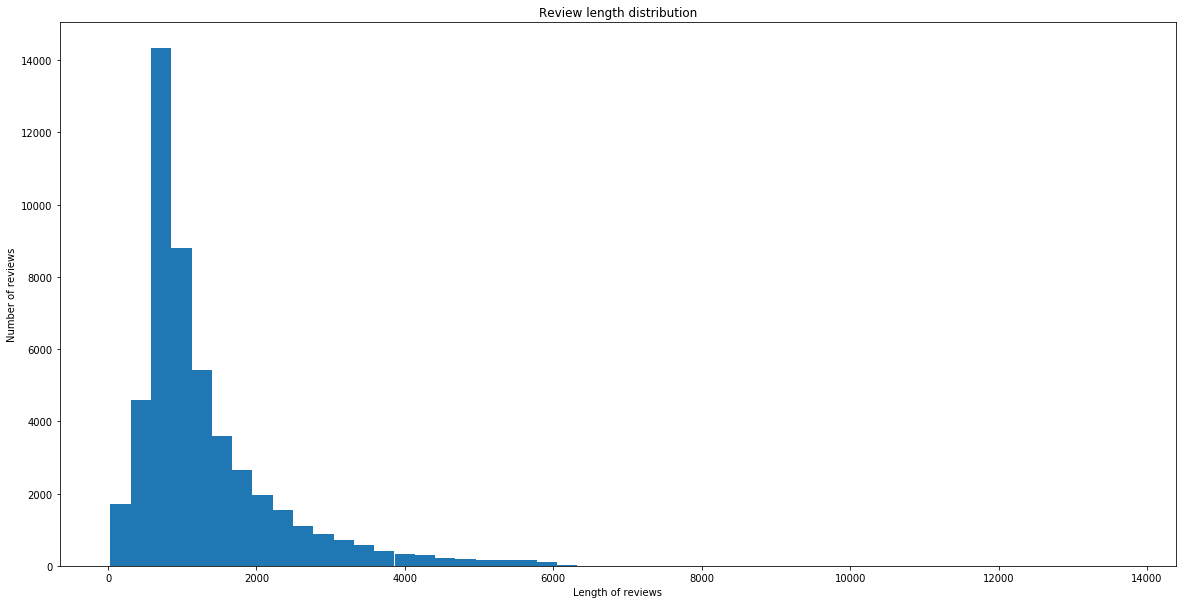

In [68]:
plt.figure(figsize=(20, 10))
plt.hist([len(rev) for rev in reviews], 50)
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews')
plt.title('Review length distribution')
plt.show()

#### Plot for words frequency distribution

In [69]:
def plot_freq_dist(reviews):
    kwargs = {
        'ngram_range' : (1, 2),
        'strip_accents' : 'unicode',
        'analyzer' : 'word',
        'max_features' : 10000,
        'max_df' : 0.7
     }
    vectorizer = CountVectorizer(**kwargs)
    vect_texts = vectorizer.fit_transform(reviews)
    ngrams = vectorizer.get_feature_names()
    num_ngrams = min(50, len(ngrams))
    all_counts = vect_texts.sum(axis=0).tolist()[0]
    all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, ngrams), reverse=True)])
    ngrams = all_ngrams[:num_ngrams]
    counts = all_counts[:num_ngrams]

    index = np.arange(num_ngrams)

    plt.figure(figsize=(40, 40))
    plt.bar(index, counts, width=0.7)
    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of words')
    plt.xticks(index, ngrams, rotation=45)
    plt.show()

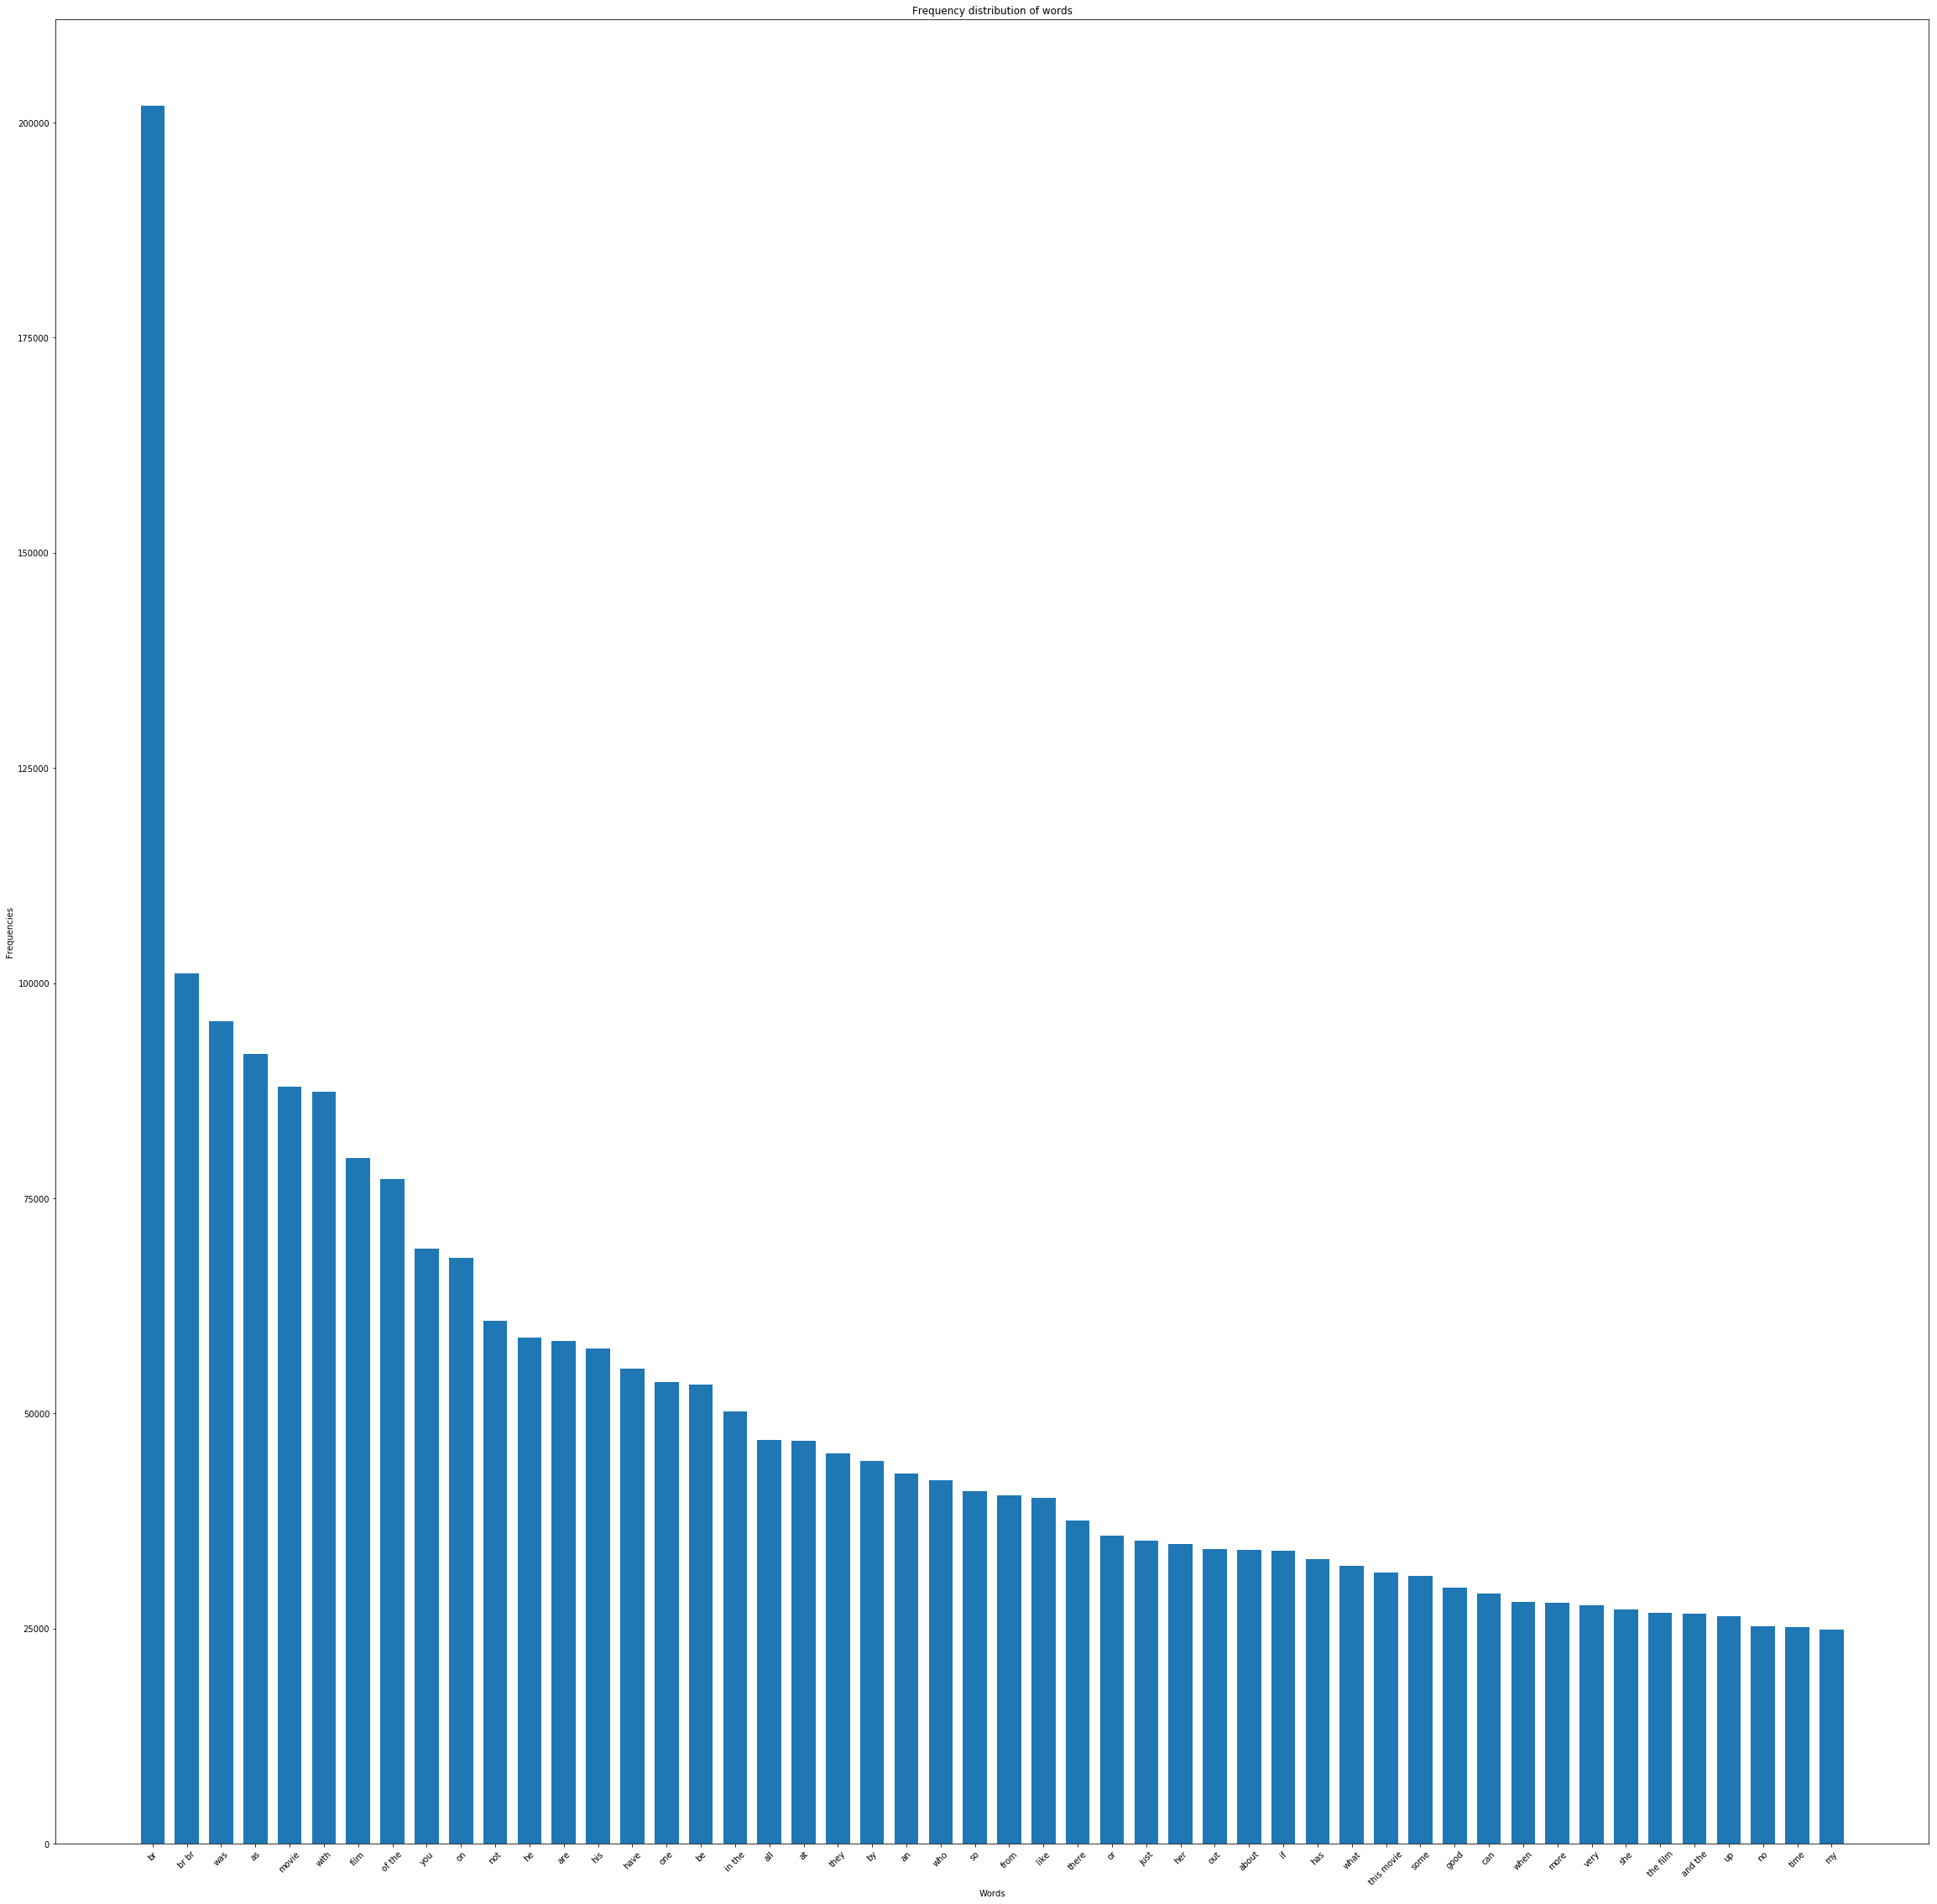

In [70]:
plot_freq_dist(reviews)

#### Preprocessing the reviews
##### Removing stop words, decoding, converting to lower case, removing special characters

In [71]:
reviews_new = []
stop_words = set(stopwords.words('english')) 
for rev in reviews:
    # Converting from byte to string and decoding utf-8
    rev = rev.decode('utf-8')
    rev = str(rev)
    # Coverting to lowercase
    rev = rev.lower()
    
    html_tags = re.compile(r'<[^>]+>')
    rev = html_tags.sub('', rev)
    rev = re.sub('[^A-Za-z0-9\']+', ' ', rev)
    rev = ' '.join([word for word in rev.split() if word not in stop_words])
    reviews_new.append(rev)

In [72]:
# Sample of reviews after preprocessing
str(reviews_new[0])

"absolute trash based closely friday 13th series practically carbon copy accept australian film people can't act upon time young boy got burnt accidentally filming music video lake eildon number years later boy grown taking revenge anybody comes lake film music video cliche ridden waste time money see curiosity aspiring actor trying learn able act lead role alan dale used star television soap opera neighbours ended x files happen"

#### Word frequency distribution after preprocessing

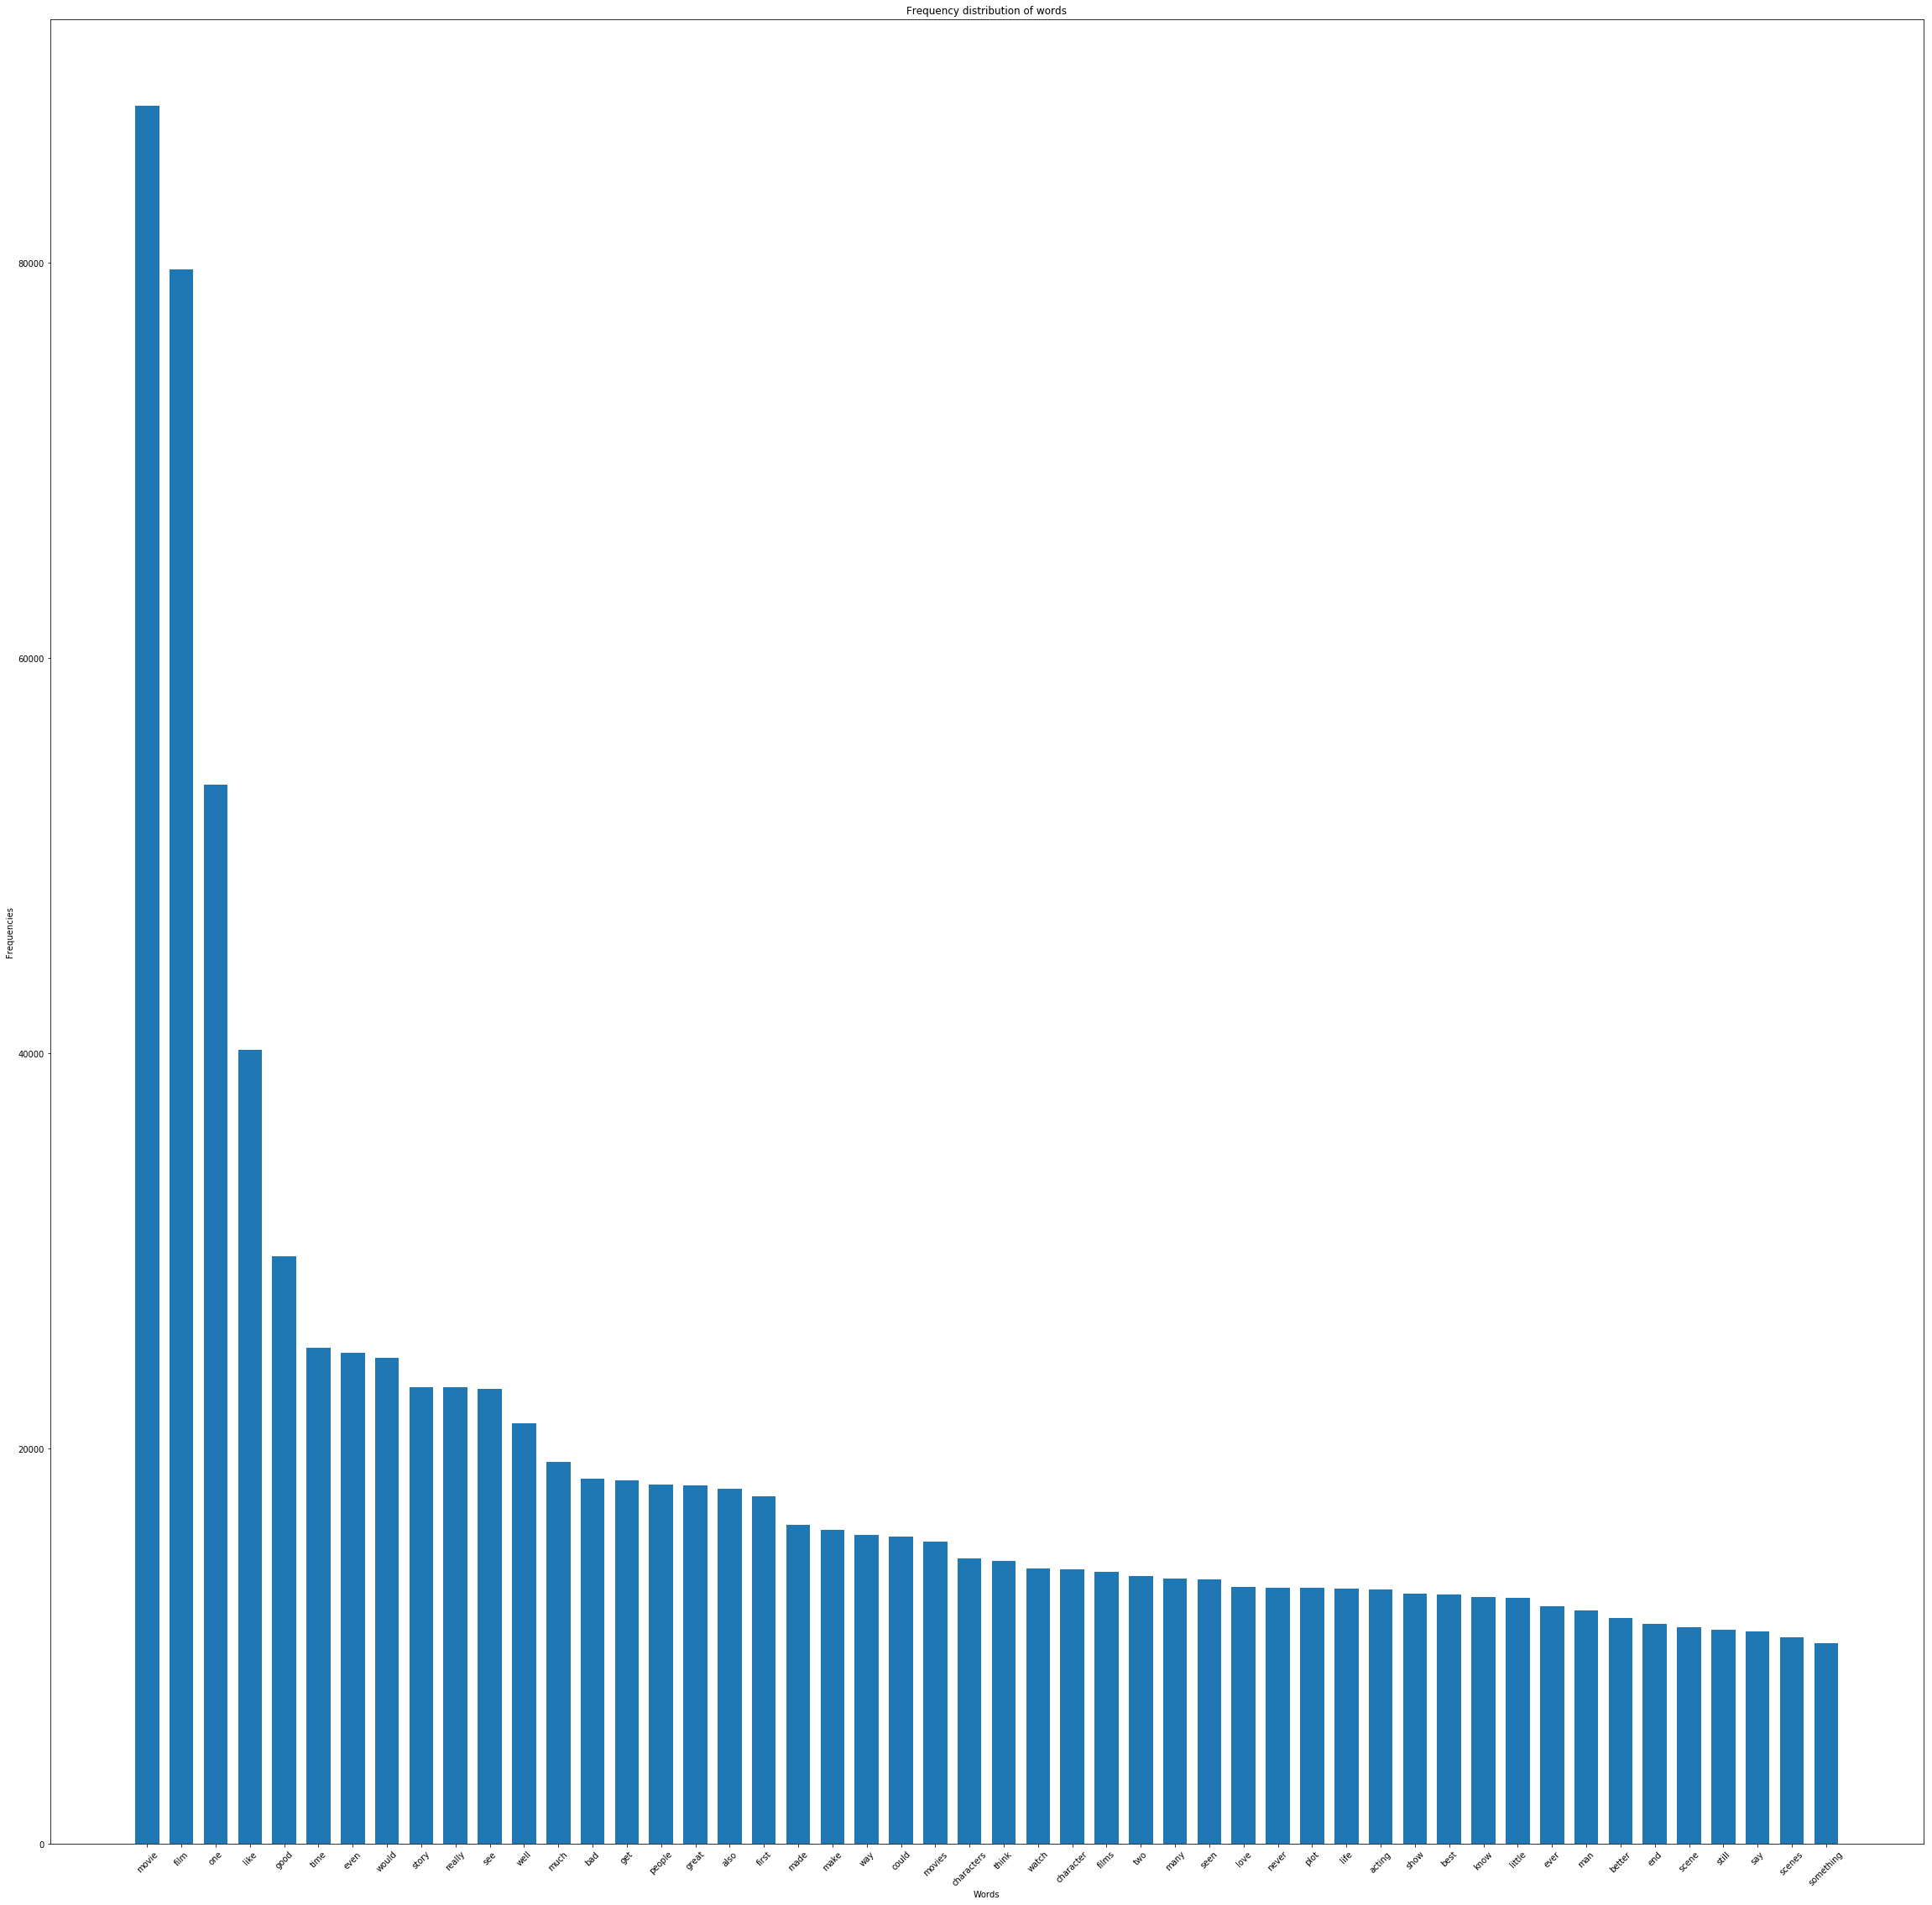

In [73]:
plot_freq_dist(reviews_new)

#### Stemming the words in the review

In [74]:
ps = PorterStemmer()
reviews_stem = []
for rev_new in reviews_new:
    rev_new = ' '.join([ps.stem(word) for word in rev_new.split()])
    reviews_stem.append(rev_new)

In [75]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
reviews_lemma = []
for rev_new in reviews_new:
    rev_new = ' '.join([lemmatizer.lemmatize(word) for word in rev_new.split()])
    reviews_lemma.append(rev_new)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Sample of review after stemming

In [76]:
reviews_stem[0]

"absolut trash base close friday 13th seri practic carbon copi accept australian film peopl can't act upon time young boy got burnt accident film music video lake eildon number year later boy grown take reveng anybodi come lake film music video clich ridden wast time money see curios aspir actor tri learn abl act lead role alan dale use star televis soap opera neighbour end x file happen"

#### Sample of review after stemming

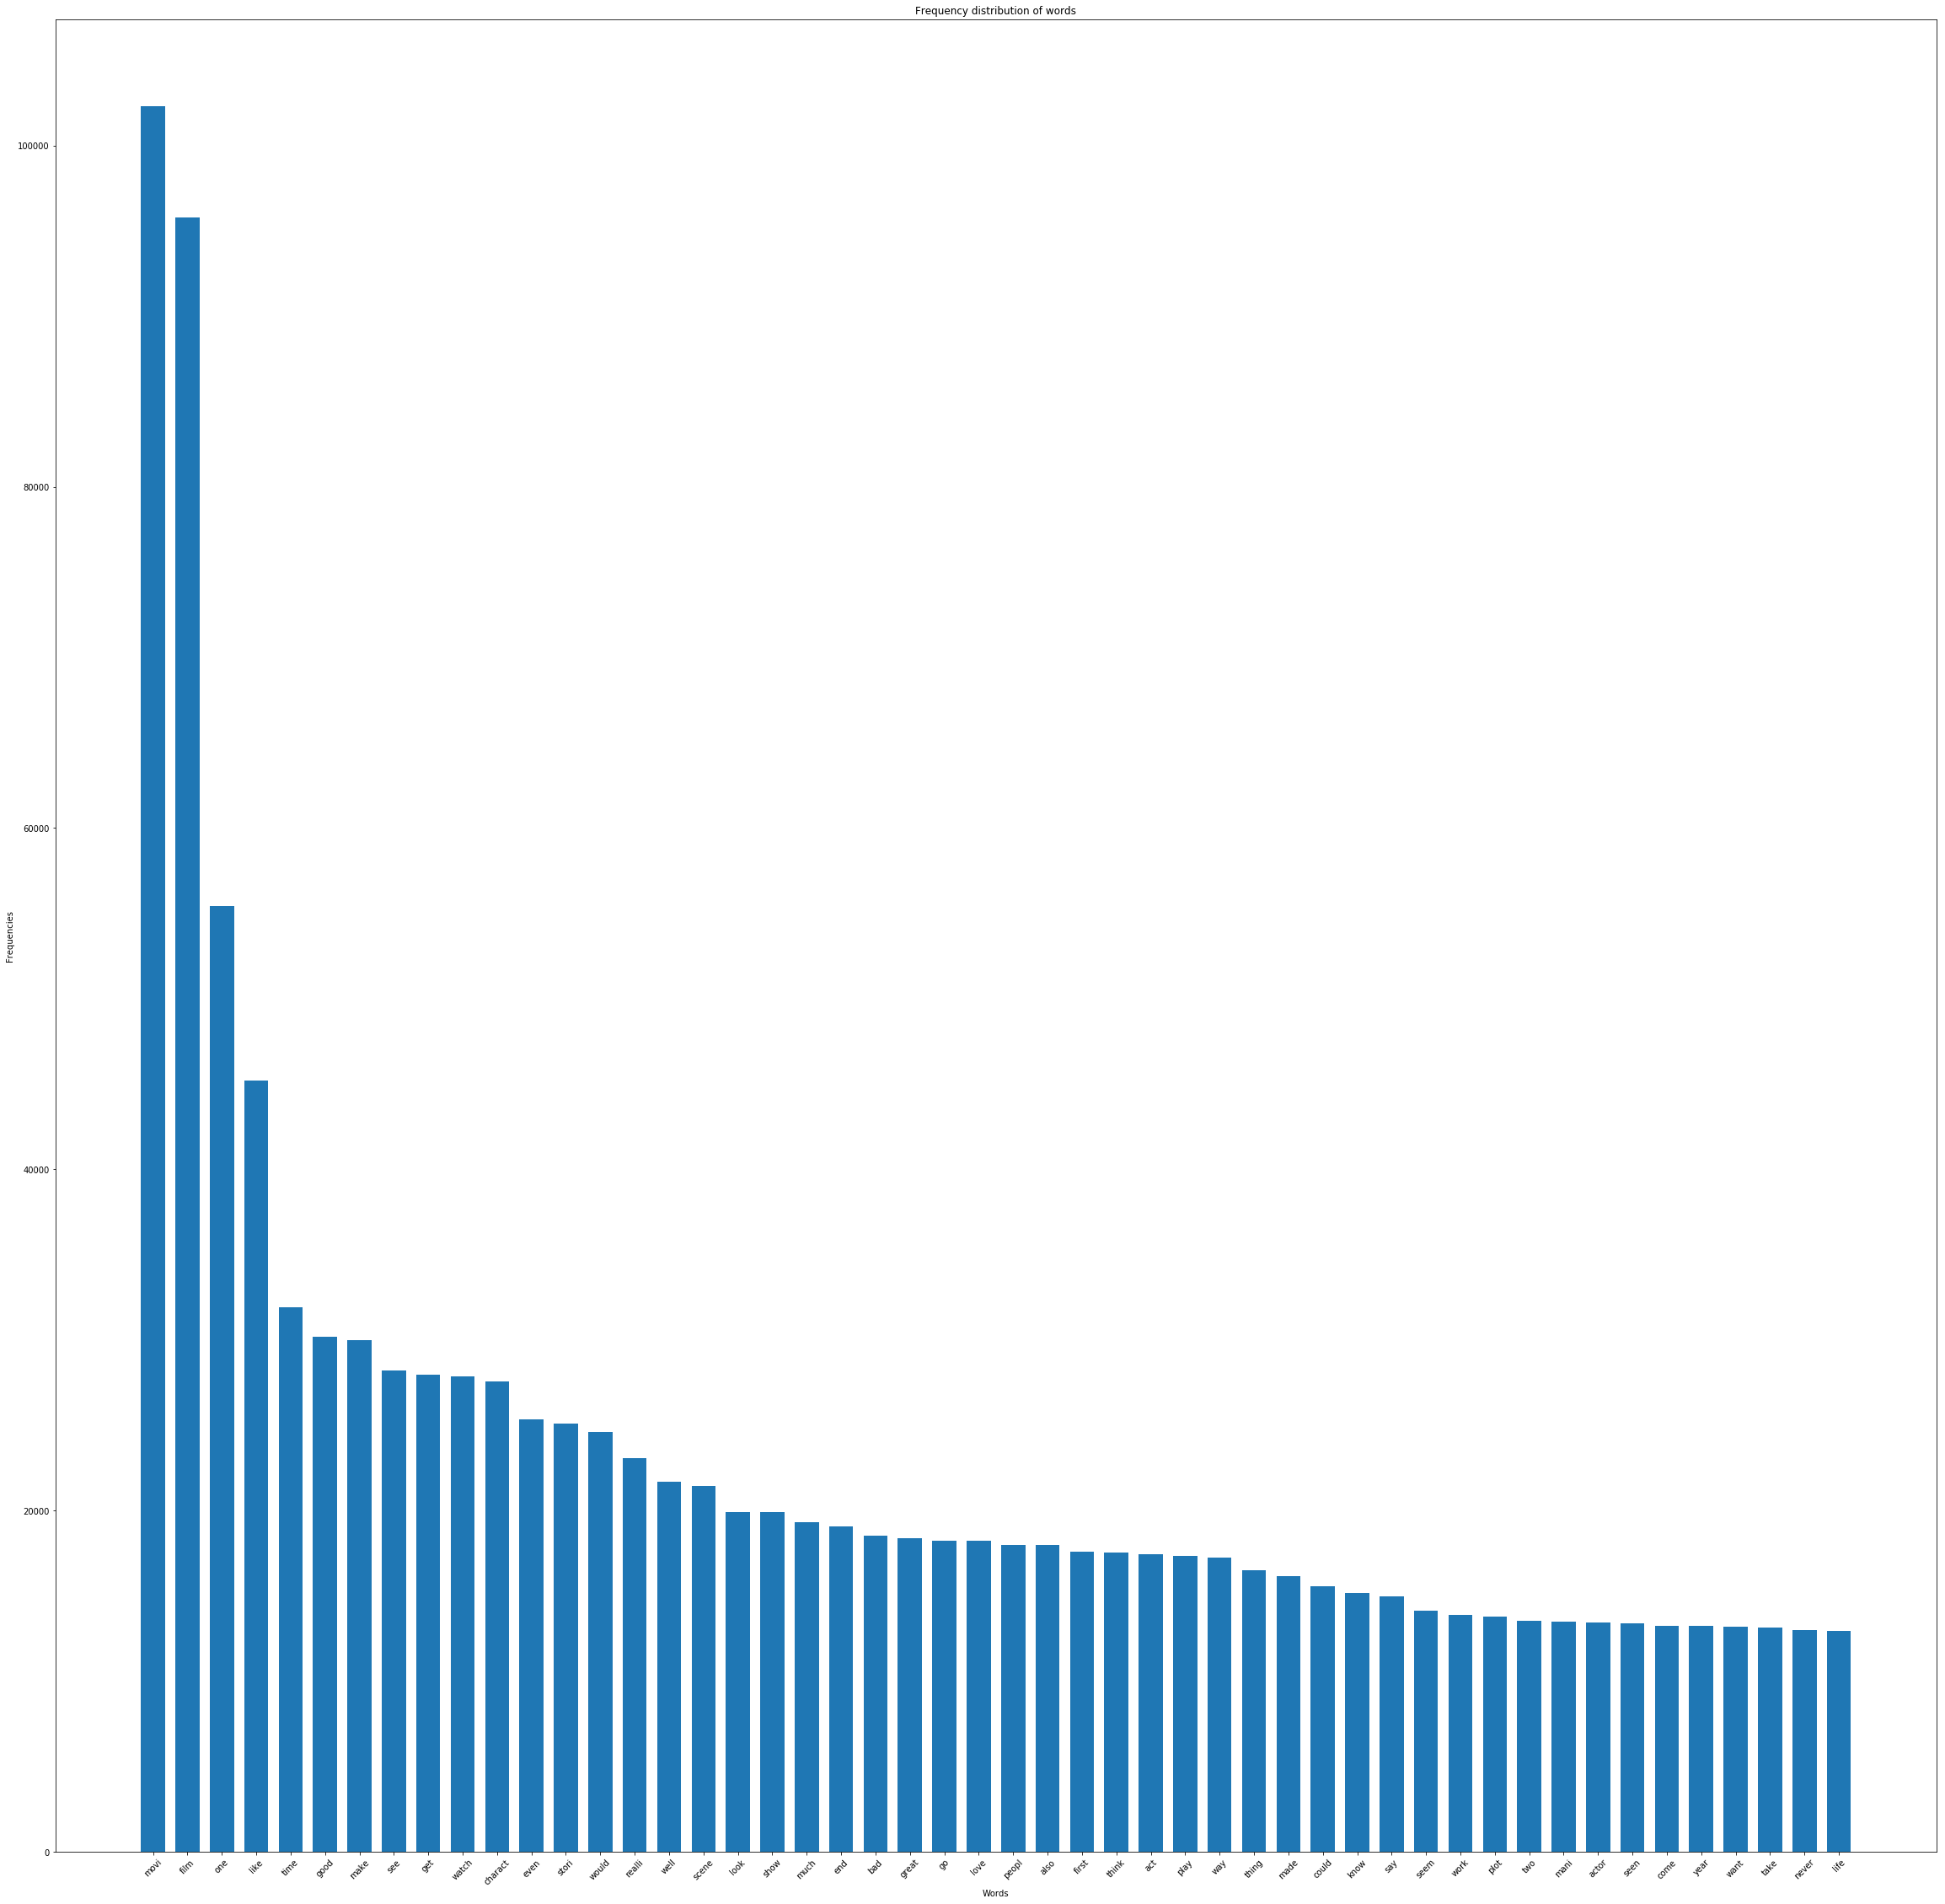

In [108]:
plot_freq_dist(reviews_stem)

#### Frequency distribution for the reviews after lemmatization

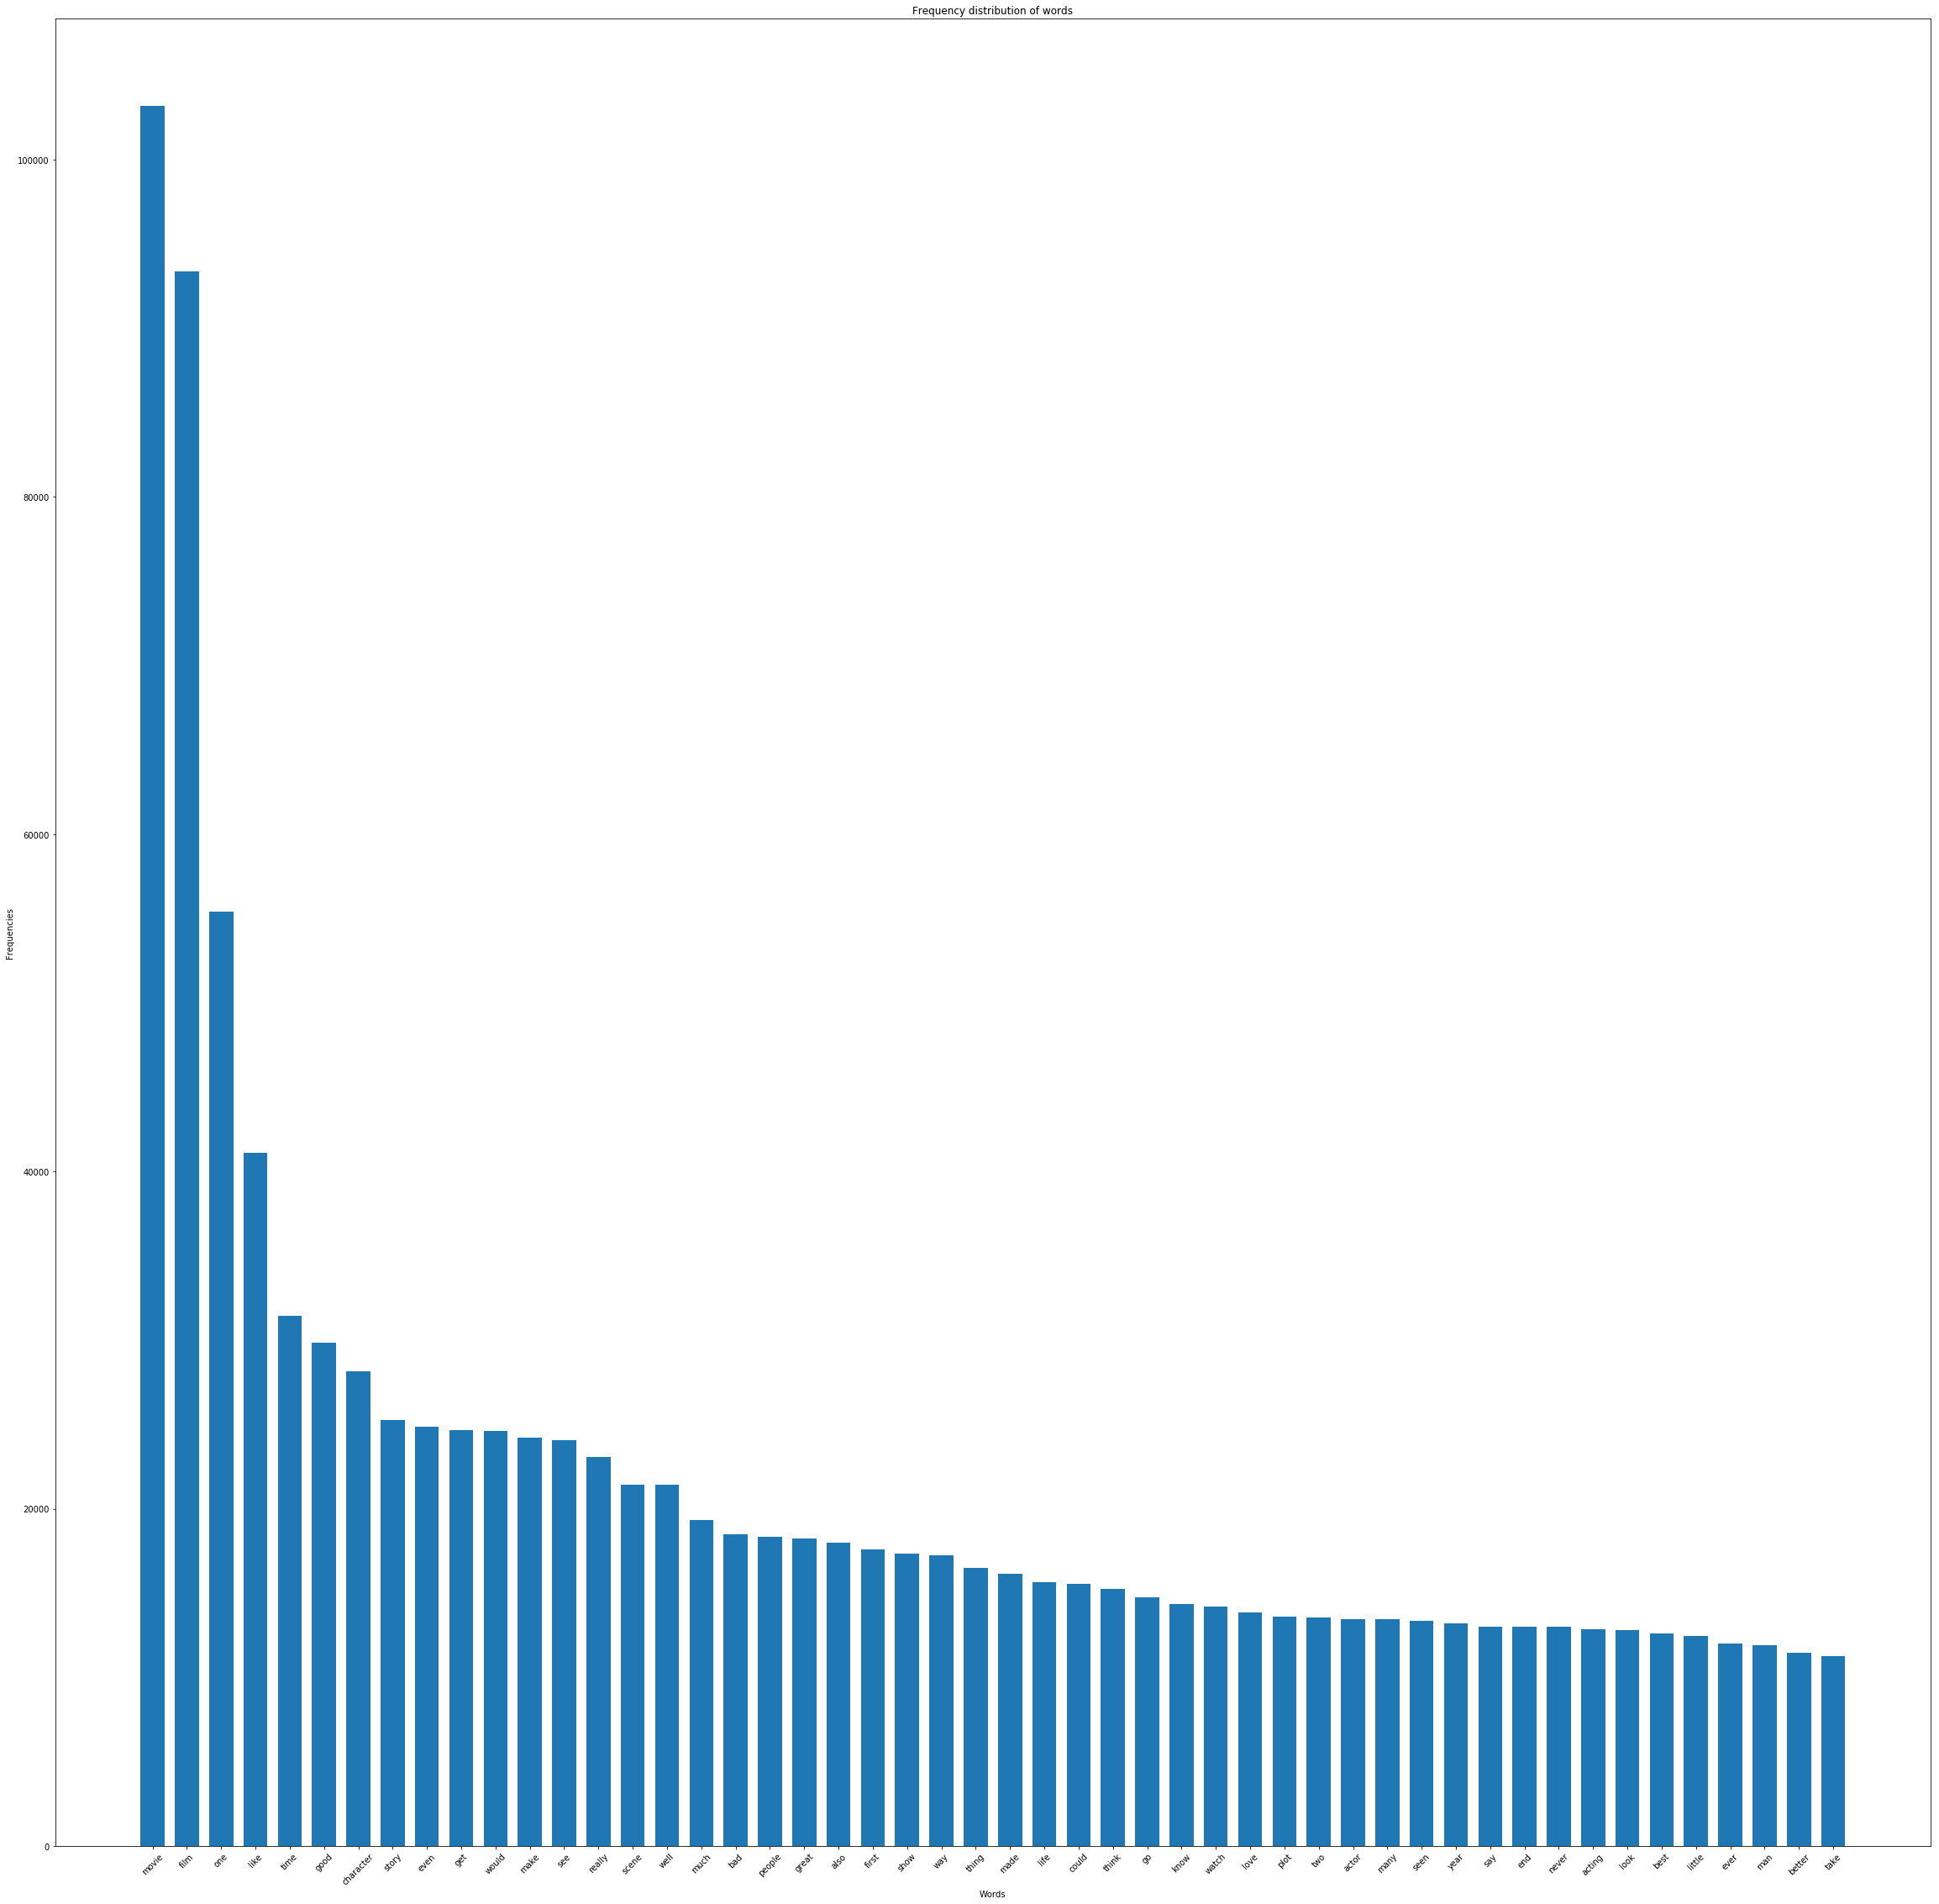

In [77]:
plot_freq_dist(reviews_lemma)

#### Function to generate various metrics from confusion matrix

In [78]:
def calculate_metrics(cm):
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    # Precision
    PPV = TP/(TP+FP)
    # Sensitivity/ Recall
    TPR = TP/(TP+FN)
    # Specificity
    TNR = TN/(TN+FP) 
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # F1 Score
    F1 = 2*((PPV*TPR)/(PPV+TPR))
    return PPV, TPR, ACC, F1

#### Function to generate models and get relevant accuracy metrics for each

In [79]:
kwargs = {
        'ngram_range' : (1, 2),
        'strip_accents' : 'unicode',
        'analyzer' : 'word',
        'max_features' : 10000,
        'max_df' : 0.7
    }
vectorizer = CountVectorizer(**kwargs)
bag_of_words = vectorizer.fit_transform(reviews_lemma)


In [81]:
BOW = bag_of_words.todense()
pca = PCA(n_components=2).fit(BOW)
data2D = pca.transform(BOW)


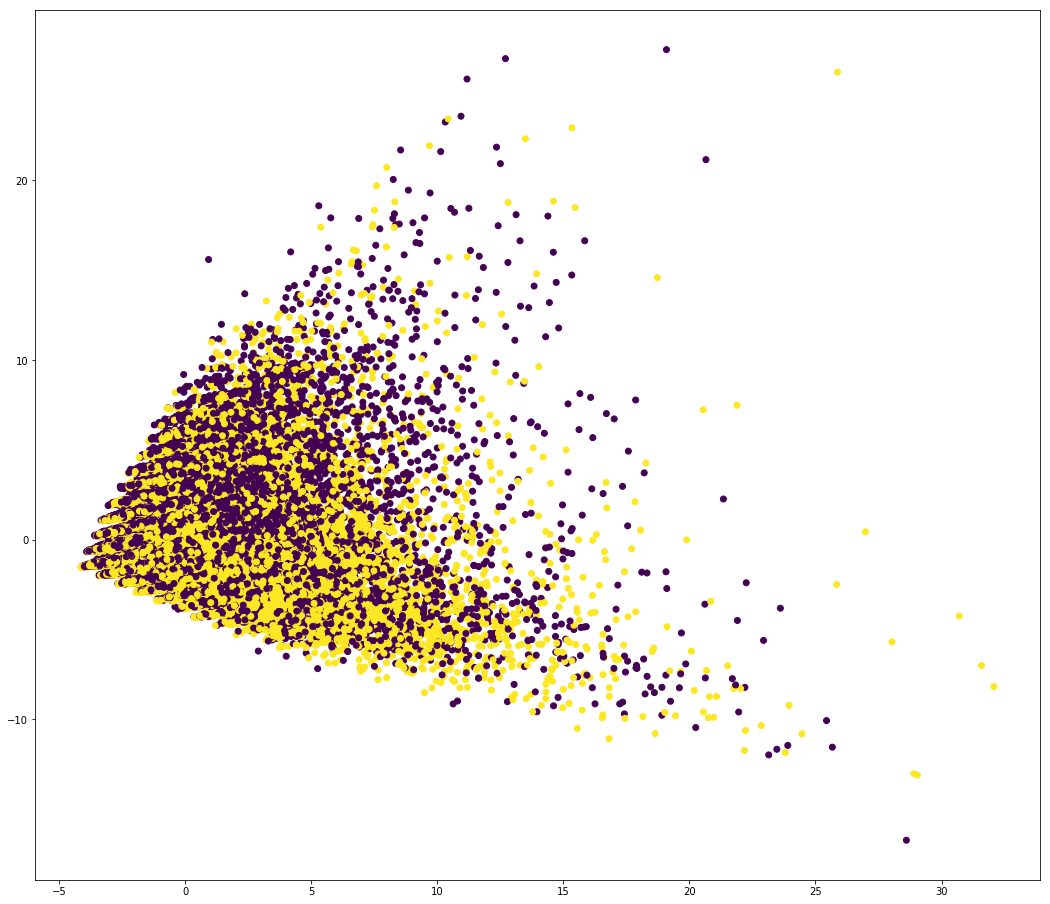

In [82]:
plt.figure(figsize=(18, 16))
plt.scatter(data2D[:,0], data2D[:,1],c=label)
plt.show() 

In [83]:
tf_idf = TfidfTransformer()
BOW_array = tf_idf.fit_transform(bag_of_words).toarray()

review_train,review_test,label_train,label_test = train_test_split(BOW_array,label,test_size = 0.30,random_state = 52)
#     return (label_test)
    

In [84]:

def build_model(reviews_final,max_features, n_gram, model, fit):
    #min document freq: term less than 3 docs, dont include
    #max_df: if word appears more then 70% of time
    #max_features: Maximum number of features
    if(model == 'Logistic'):
        classifier = LogisticRegression(solver = 'liblinear',random_state = 52)
    if(model == 'SVC'):
        classifier = LinearSVC(random_state = 52)
    if(model == 'MultinomialNB'):
        classifier = MultinomialNB()
    if(model == 'RF'):
        classifier = RandomForestClassifier(n_estimators=100, random_state = 52)
    if(model == 'DecisionTree'):
        classifier = DecisionTreeClassifier(random_state = 52)
    classifier.fit(review_train,label_train)
    classifier_name = 'classifier_'+ str(model) +'.pickle'
    with open(classifier_name,'wb') as f:
        pickle.dump(classifier,f)
    
    pred_labels = classifier.predict(review_test)
    cm = confusion_matrix(label_test,pred_labels)
    print(cm)
    precision, recall, accuracy, f1 = calculate_metrics(cm)
    print ("Precision", precision)
    print ("Recall", recall)
    print ("Accuracy", accuracy)
    print ("F1 score", f1)
    pred_labels_list = pred_labels.tolist()
    if(fit == 'highest'):
        return pred_labels_list, cm, precision, recall, accuracy, f1

#### Logistic Regression

In [85]:
build_model(reviews_new,5000, 1, 'Logistic', fit = 'try')

[[6646  911]
 [ 736 6707]]
Precision 0.8794495170041021
Recall 0.9002980222162016
Accuracy 0.8902
F1 score 0.8897516567373988


In [86]:
build_model(reviews_lemma, 5000, 1, 'Logistic', fit = 'try')

[[6646  911]
 [ 736 6707]]
Precision 0.8794495170041021
Recall 0.9002980222162016
Accuracy 0.8902
F1 score 0.8897516567373988


In [87]:
logistic_pred_labels_list, logistic_cm, logistic_precision, logistic_recall, logistic_accuracy, logistic_f1 = build_model(reviews_lemma, 5000, 2, 'Logistic', fit = 'highest')

[[6646  911]
 [ 736 6707]]
Precision 0.8794495170041021
Recall 0.9002980222162016
Accuracy 0.8902
F1 score 0.8897516567373988


In [88]:
# SVC

In [89]:
svc_pred_labels_list, svc_cm, svc_precision, svc_recall, svc_accuracy, svc_f1 = build_model(reviews_lemma, 5000, 2, 'SVC', fit = 'highest')

[[6682  875]
 [ 830 6613]]
Precision 0.8842133121609104
Recall 0.8895101171458999
Accuracy 0.8863333333333333
F1 score 0.8868538058265313


#### MultinomialNB

In [90]:
mnb_pred_labels_list, mnb_cm, mnb_precision, mnb_recall, mnb_accuracy, mnb_f1 = build_model(reviews_lemma, 5000, 2, 'MultinomialNB', fit = 'highest')

[[6452 1105]
 [ 913 6530]]
Precision 0.8537779542146354
Recall 0.8760353021045485
Accuracy 0.8654666666666667
F1 score 0.8647634365366572


#### RandomForestClassifier

In [91]:
rf_pred_labels_list, rf_cm, rf_precision, rf_recall, rf_accuracy, rf_f1 = build_model(reviews_lemma, 5000, 2, 'RF', fit = 'highest')

[[6444 1113]
 [1143 6300]]
Precision 0.8527193330686781
Recall 0.8493475682087782
Accuracy 0.8496
F1 score 0.8510301109350238


#### DecisionTreeClassifier

In [97]:
dt_pred_labels_list, dt_cm, dt_precision, dt_recall, dt_accuracy, dt_f1 = build_model(reviews_lemma, 5000, 2, 'DecisionTree', fit = 'highest')

[[5460 2097]
 [2137 5306]]
Precision 0.722508932115919
Recall 0.7187047518757405
Accuracy 0.7177333333333333
F1 score 0.7206018213013065


In [98]:
#Ensemble

In [99]:
# Since 

In [100]:
# label_test = create_test_train(2,5000,0.7)
def fn_ensemble(w1,w2,w3,w4):
    
    pred_labels = []
    for i in range(len(dt_pred_labels_list)):
        x = (w1*logistic_pred_labels_list[i] + w2*svc_pred_labels_list[i] + w3 * mnb_pred_labels_list[i] + w4* rf_pred_labels_list[i])/(w1+w2+w3+w4)
        if x>= 0.5:
            pred_labels.append(1)
        if x < 0.5:
            pred_labels.append(0)
        
    cm = confusion_matrix(label_test,pred_labels)
    print(cm)
    precision, recall, accuracy, f1 = calculate_metrics(cm)
    print ("Precision", precision)
    print ("Recall", recall)
    print ("Accuracy", accuracy)
    print ("F1 score", f1)
    

In [101]:
fn_ensemble(0.4,0.4,0.1,.1)

[[6607  950]
 [ 674 6769]]
Precision 0.8742887389175599
Recall 0.9074302980359841
Accuracy 0.8917333333333334
F1 score 0.8905512872354764


In [102]:
fn_ensemble(0.3,0.3,0.2,0.2)

[[6607  950]
 [ 674 6769]]
Precision 0.8742887389175599
Recall 0.9074302980359841
Accuracy 0.8917333333333334
F1 score 0.8905512872354764


In [112]:
fn_ensemble(0.25,0.25,0.25,0.25)

[[6483 1074]
 [ 592 6851]]
Precision 0.8578801111552203
Recall 0.9163250883392227
Accuracy 0.8889333333333334
F1 score 0.8861399671951886


In [104]:
# Neural network

In [198]:
def create_nn_model(dropout_rate, input_shape, layers):
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=64, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [199]:
nn_model = create_nn_model(dropout_rate=0.4,input_shape=review_train.shape[1:],layers=1)

In [200]:
optimizer = tf.keras.optimizers.Adam(lr=0.3)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
# Create callback for early stopping on validation loss. If the loss does
# not decrease on two consecutive tries, stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    
    # Train and validate model
nn_model.fit(review_train, label_train, epochs=100,verbose=2, batch_size=128, validation_split=0.1, callbacks= callbacks)


Train on 31500 samples, validate on 3500 samples
Epoch 1/100
 - 6s - loss: 0.5063 - acc: 0.8141 - val_loss: 0.3556 - val_acc: 0.8746
Epoch 2/100
 - 5s - loss: 0.4826 - acc: 0.8517 - val_loss: 0.4314 - val_acc: 0.8697
Epoch 3/100
 - 4s - loss: 0.4935 - acc: 0.8568 - val_loss: 0.4292 - val_acc: 0.8743


In [201]:
nn_pred = nn_model.predict(review_test)


In [202]:
label_pred = [0 if (x<0.5) else 1 for x in nn_pred ]

In [203]:
cm = confusion_matrix(label_test,label_pred)
print(cm)
precision, recall, accuracy, f1 = calculate_metrics(cm)
print ("Precision", precision)
print ("Recall", recall)
print ("Accuracy", accuracy)
print ("F1 score", f1)


[[6424 1133]
 [ 844 6599]]
Precision 0.8500727802037845
Recall 0.8838745184369841
Accuracy 0.8682
F1 score 0.8666441821247892
